In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu, ttest_ind

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# Load the processed data as pickle files to keep data types
data_processed = "../data/processed"
apps = pd.read_pickle(f"{data_processed}/applications.pkl")
company = pd.read_pickle(f"{data_processed}/company.pkl")
payments = pd.read_pickle(f"{data_processed}/payment.pkl")
df = pd.read_pickle(f"{data_processed}/merged.pkl")

# Task 2

Does the risk score assigned to the construction companies reflect their default risk

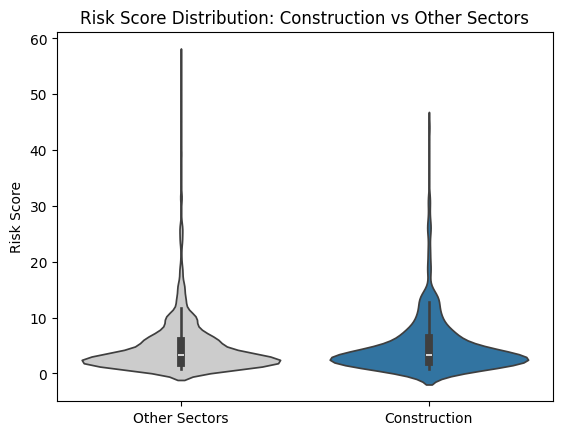

In [4]:
blue_construction_palette = palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}

sns.violinplot(
    data=df,
    x="sector_group",
    y="risk_score",
    palette=blue_construction_palette
)
plt.title("Risk Score Distribution: Construction vs Other Sectors")
plt.ylabel("Risk Score")
plt.xlabel("")
plt.show()

In [5]:
risk_construction = df[df['is_construction'] == True]['risk_score']
risk_others = df[df['is_construction'] == False]['risk_score']

stat, p = mannwhitneyu(risk_construction, risk_others, alternative='greater')  # H1: construction > others

print(f"Mann–Whitney U statistic: {stat:.2f}")
print(f"P-value: {p:.4f}")

Mann–Whitney U statistic: 1261680.50
P-value: 0.1158


The difference in risk score is not significant.

## The code below was used to generate helpful plots and graphs as part of the presentation.

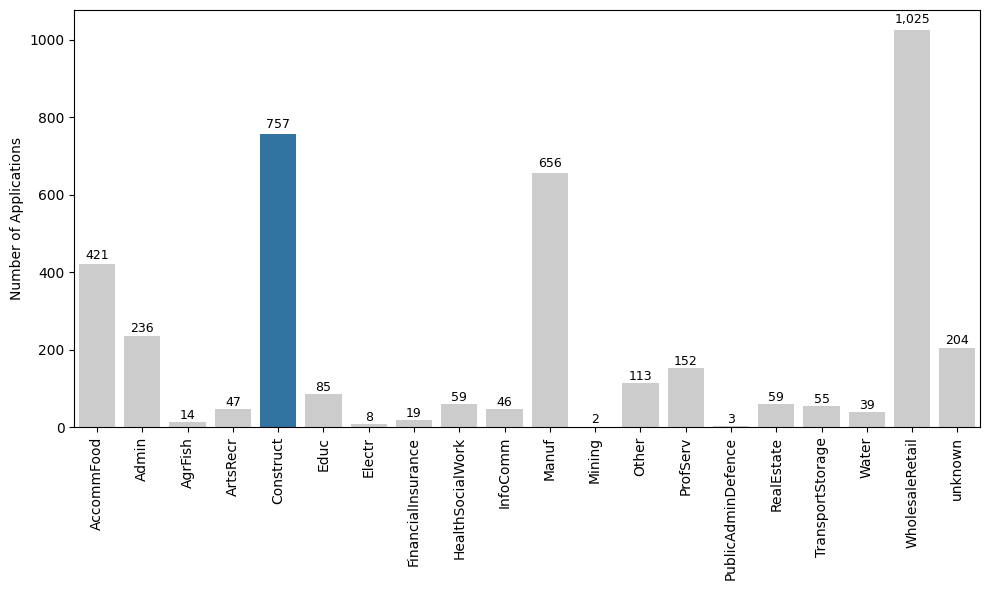

In [6]:
# Get unique industry segments
industry_palette = df["industry_segment"].unique()

# Create palette: blue for 'Construct', grey for others
my_palette = {seg: ("#1f77b4" if seg == "Construct" else "#cccccc") for seg in industry_palette}

# Count applications per industry segment
app_counts = df['industry_segment'].value_counts().reset_index()
app_counts.columns = ['industry_segment', 'count']

# Ensure category order if needed
app_counts['industry_segment'] = pd.Categorical(
    app_counts['industry_segment'],
    categories=industry_palette,
    ordered=True
)

# Sort by industry name (or by count if preferred)
app_counts = app_counts.sort_values('industry_segment')

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=app_counts,
    x='industry_segment',
    y='count',
    palette=my_palette
)

# Add values above bars using the patches in ax
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(
        x,
        height + height * 0.01,  # slightly above bar
        f"{int(height):,}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# plt.title('Number of Applications by Industry Segment')
plt.ylabel('Number of Applications')
plt.xlabel('')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


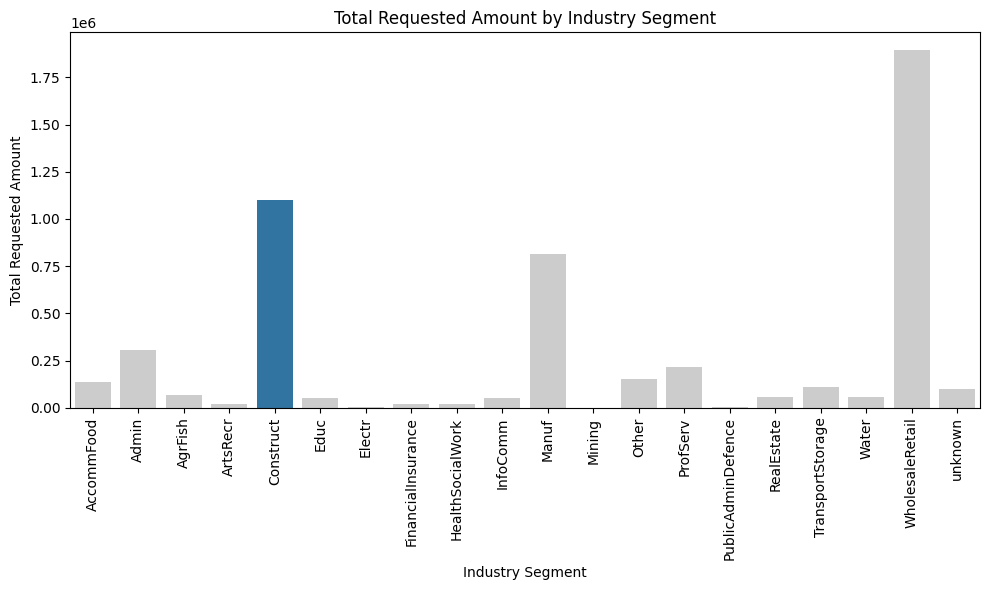

In [7]:

# Sum of requested amount per industry segment
amount_sums = df.groupby('industry_segment')['requested_amount_clean'].sum().reset_index()
amount_sums.columns = ['industry_segment', 'total_requested_amount']

# Ensure category order matches the palette definition
industry_palette = df["industry_segment"].unique()
amount_sums['industry_segment'] = pd.Categorical(
    amount_sums['industry_segment'],
    categories=industry_palette,
    ordered=True
)
amount_sums = amount_sums.sort_values('industry_segment')

# Create the same color palette
my_palette = {seg: ("#1f77b4" if seg == "Construct" else "#cccccc") for seg in industry_palette}

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=amount_sums,
    x='industry_segment',
    y='total_requested_amount',
    palette=my_palette
)
plt.title('Total Requested Amount by Industry Segment')
plt.ylabel('Total Requested Amount')
plt.xlabel('Industry Segment')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
sector_colors = {
    "Water": "#ff7f0e",
    "Construct": "#1f77b4",
    "TransportStorage": "#2ca02c",
    "unknown": "#d62728",
    "WholesaleRetail": "#9467bd",
    "Electr": "#8c564b",
    "Manuf": "#e377c2",
    "Other": "#7f7f7f",
    "Admin": "#bcbd22",
    "RealEstate": "#17becf",
    "HealthSocialWork": "#aec7e8",
    "ArtsRecr": "#ffbb78",
    "ProfServ": "#98df8a",
    "Educ": "#ff9896",
    "InfoComm": "#c5b0d5",
    "FinancialInsurance": "#c49c94",
    "Mining": "#f7b6d2",
    "AgrFish": "#dbdb8d",
    "PublicAdminDefence": "#9edae5"
}

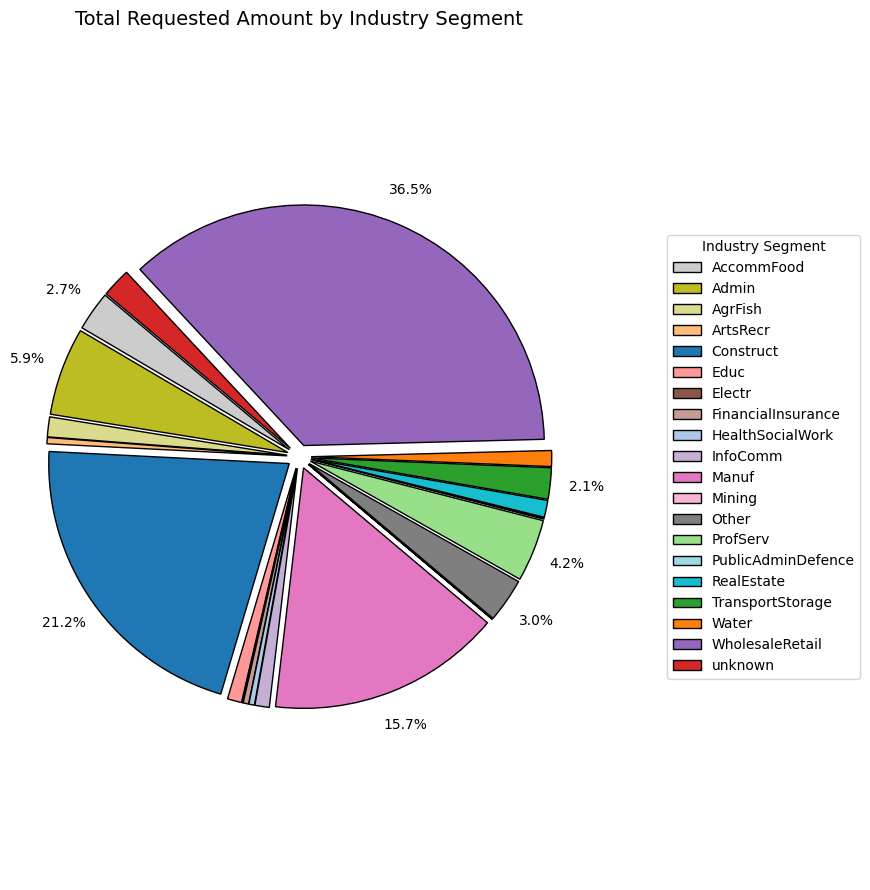

In [9]:
# Sum requested amounts by industry segment
requested_sum = df.groupby('industry_segment')['requested_amount_clean'].sum()

# Map colors according to sector_colors dict (handle missing keys)
colors = [sector_colors.get(seg, "#cccccc") for seg in requested_sum.index]

# Explode slices for better separation
explode = [0.05] * len(requested_sum)

# Show % only if >= 2%
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= 2 else ''

plt.figure(figsize=(9, 9))
wedges, texts, autotexts = plt.pie(
    requested_sum,
    labels=None,
    colors=colors,
    autopct=autopct_func,
    pctdistance=1.15,
    startangle=140,
    explode=explode,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 10}
)

plt.legend(
    wedges, requested_sum.index,
    title="Industry Segment",
    loc="center left",
    bbox_to_anchor=(1.15, 0, 0.5, 1),  # moved from 1 to 1.15
    fontsize=10
)

plt.title('Total Requested Amount by Industry Segment', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Unused Code
The below code are attempts to isolate sub groups within the construction sector which help to identify the more risky applications. These were not used in the report.

In [10]:
# Isolate construction companies
df_construction = df[df['is_construction'] == True].copy()

# Define payment status
df_construction['payment_status'] = 'on_time'
df_construction.loc[df_construction['default_status'] == True, 'payment_status'] = 'default'
df_construction.loc[(df_construction['default_status'] == False) & 
                    (df_construction['paid_on_time'] == False), 'payment_status'] = 'late'

defaults_palette = {
    'default': 'red',
    'late': 'orange',
    'on_time': 'lightgrey'
}


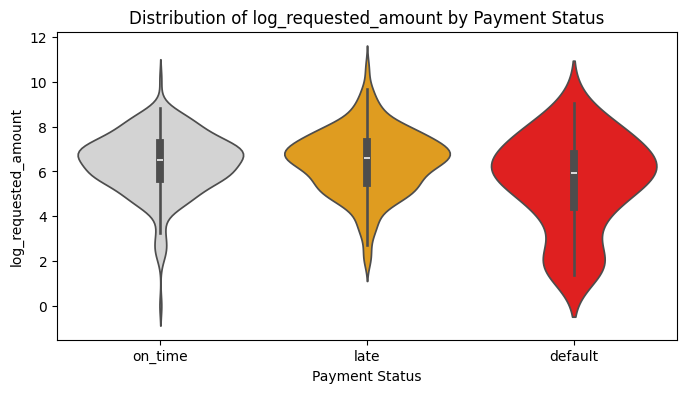

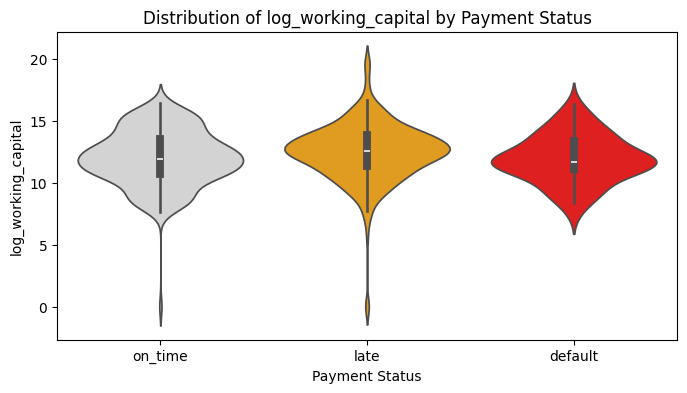

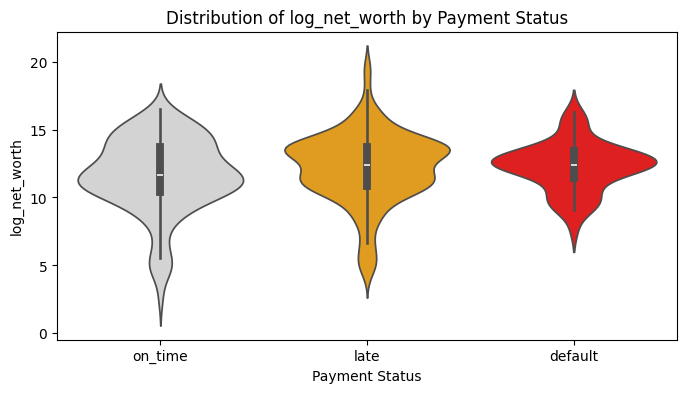

In [11]:

features = ['log_requested_amount', 'log_working_capital', 'log_net_worth']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.violinplot(
        x='payment_status',
        y=feature,
        data=df_construction,
        order=['on_time', 'late', 'default'],
        palette=defaults_palette
    )
    plt.title(f'Distribution of {feature} by Payment Status')
    plt.xlabel('Payment Status')
    plt.ylabel(feature)
    plt.show()

In [12]:
# Create interaction term
df_construction['term_1'] = (
    df_construction['log_requested_amount'] * np.log1p(df_construction['days_until_due']) #(df_construction['days_until_due'])
)
# Create interaction term
df_construction['term_2'] = (
    df_construction['log_working_capital']
)

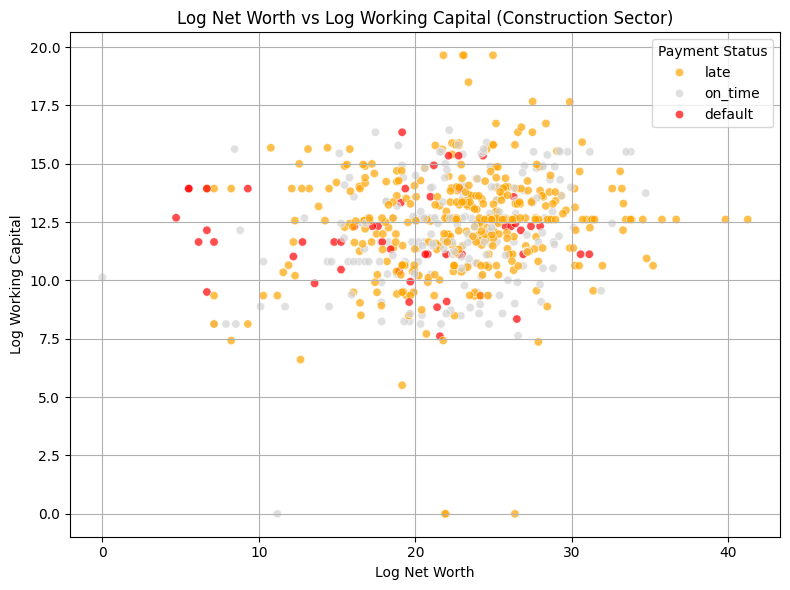

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_construction,
    x='term_1',
    y='term_2',
    hue='payment_status',
    palette=defaults_palette,
    alpha=0.7
)
plt.title('Log Net Worth vs Log Working Capital (Construction Sector)')
plt.xlabel('Log Net Worth')
plt.ylabel('Log Working Capital')
plt.legend(title='Payment Status')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
df['external_credit_rating_label'].unique()

['Very Low Risk', 'Moderate Risk', 'Low Risk', NaN, 'High Risk']
Categories (4, object): ['Very Low Risk' < 'Low Risk' < 'Moderate Risk' < 'High Risk']

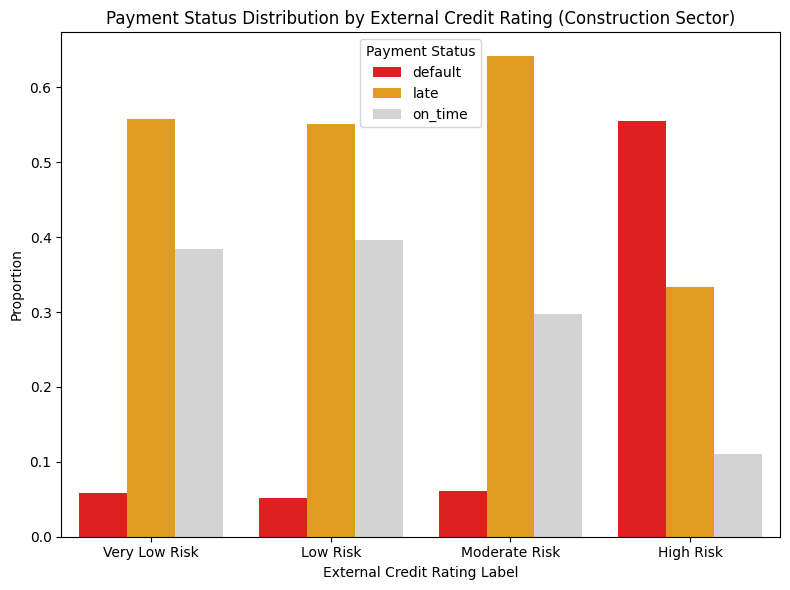

In [15]:
# Step 1: Group and count
count_data = (
    df_construction
    .groupby(['external_credit_rating_label', 'payment_status'])
    .size()
    .reset_index(name='count')
)

# Step 2: Calculate proportions per rating label
total_counts = count_data.groupby('external_credit_rating_label')['count'].transform('sum')
count_data['proportion'] = count_data['count'] / total_counts

plt.figure(figsize=(8, 6))
sns.barplot(
    data=count_data,
    x='external_credit_rating_label',
    y='proportion',
    hue='payment_status',
    palette={'default': 'red', 'late': 'orange', 'on_time': 'lightgrey'}
)
plt.title('Payment Status Distribution by External Credit Rating (Construction Sector)')
plt.ylabel('Proportion')
plt.xlabel('External Credit Rating Label')
plt.legend(title='Payment Status')
plt.tight_layout()
plt.show()

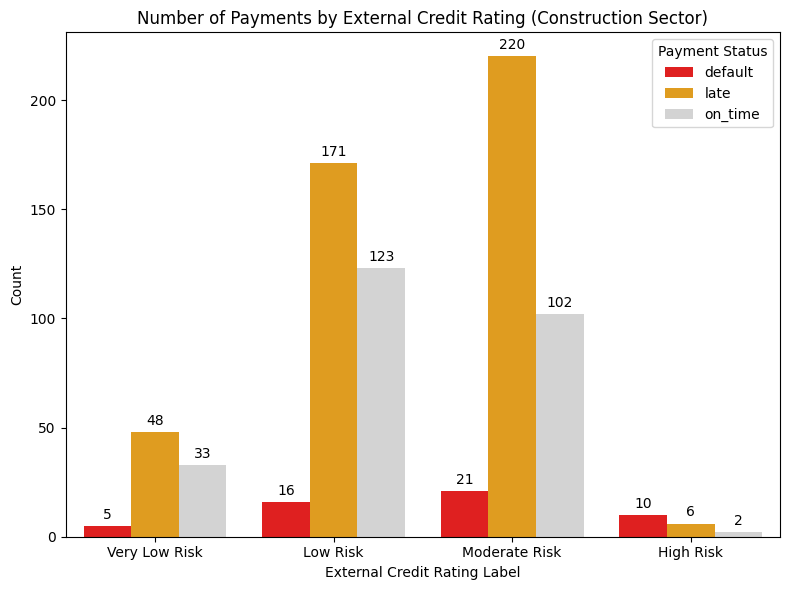

In [16]:
# Step 1: Group and count
count_data = (
    df_construction
    .groupby(['external_credit_rating_label', 'payment_status'])
    .size()
    .reset_index(name='count')
)

# Optional: ensure ordinal category order
ordinal_order = ['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk']
count_data['external_credit_rating_label'] = count_data['external_credit_rating_label'].astype(
    pd.api.types.CategoricalDtype(categories=ordinal_order, ordered=True)
)

# Plot
plt.figure(figsize=(8, 6))
barplot = sns.barplot(
    data=count_data,
    x='external_credit_rating_label',
    y='count',
    hue='payment_status',
    palette={'default': 'red', 'late': 'orange', 'on_time': 'lightgrey'}
)

# Add count labels above each bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Number of Payments by External Credit Rating (Construction Sector)')
plt.ylabel('Count')
plt.xlabel('External Credit Rating Label')
plt.legend(title='Payment Status')
plt.tight_layout()
plt.show()

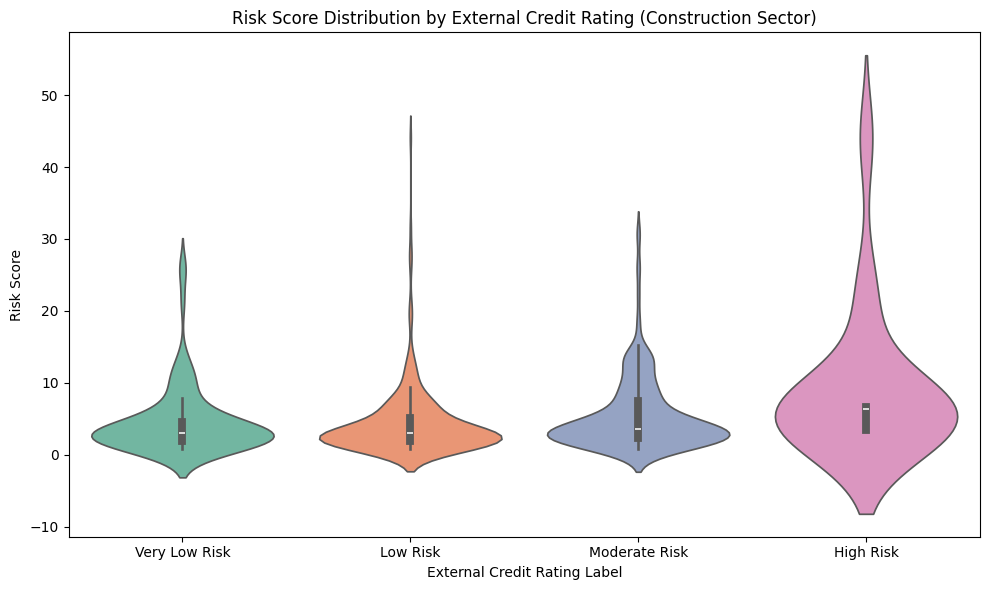

In [17]:
# Plot
ordinal_order = ['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk']
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_construction,
    x='external_credit_rating_label',
    y='risk_score',
    order=ordinal_order,
    palette='Set2'
)
plt.title('Risk Score Distribution by External Credit Rating (Construction Sector)')
plt.xlabel('External Credit Rating Label')
plt.ylabel('Risk Score')
plt.tight_layout()
plt.show()